# NILMTK API using UKDALE dataset
Notebook to test the usage of UKDALE for the API.

This notebook demonstrates the use of NILMTK's ExperimentAPI - a NILMTK interface which allows NILMTK users to focus on which experiments to run rather than on the code required to run such experiments.

- The objective of using API is to perform quick experiments using existing algorithms inside NILMTK

Extracted from: __[NILMTK API Tutorial](https://github.com/nilmtk/nilmtk-contrib/blob/master/sample_notebooks/NILMTK%20API%20Tutorial.ipynb)__

Importing the API and libraries to be used

In [4]:
# Importing libraries for working with DataFrames and visualizations
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

# Importing the following for working with NILM dataset
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CO, FHMMExact, Hart85, Mean
from nilmtk.legacy.disaggregate import CombinatorialOptimisation
from nilmtk.utils import print_dict
from nilmtk.api import API

plt.style.use('ggplot')
%matplotlib inline

## Experiment 1 - List appliances
We enter the values for the different parameters in the dictionary. Since we need **multiple appliances**, we enter the names of all the required appliances in the 'appliances' parameter.

In [5]:
experiment1 = {
  'power': {'mains': ['apparent','active'],'appliance': ['apparent','active']},
  'sample_rate': 60,
  'appliances': ['fridge freezer', 'kettle', 'microwave'],
  'methods': {"CO":CO({})},
  'train': {    
    'datasets': {
        'UK-DALE': {
            'path': '../Dataset/ukdale.h5',
            'buildings': {
                1: {
                    'start_time': '2013-08-01',
                    'end_time': '2013-08-15'
                    }
                }                
            }
        }
    },
  'test': {
    'datasets': {
        'UK-DALE': {
            'path': '../Dataset/ukdale.h5',
            'buildings': {
                1: {
                    'start_time': '2013-09-01',
                    'end_time': '2013-09-07'
                    }
                }
            }
        },
        'metrics':['rmse']
    }
}

In this example experimental setup, we have set the sample rate at **60Hz** and use **Combinatorial Optimisation** to disaggregate the required appliances from **building 1** in the **UK-Dale** dataset with the **RMSE metric** to measure the accuracy. We also specify the dates for training and testing.

Next we provide this experiment dictionary as input to the API.

In [6]:
api_results_experiment_1 = API(experiment1)

Joint Testing for all algorithms
Loading data for  UK-DALE  dataset


/opt/conda/envs/nilmtk-env/lib/python3.7/site-packages/nilmtk/utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Dropping missing values
Generating predictions for : CO
...............CO disaggregate_chunk running.............
............  rmse  ..............
                        CO
fridge freezer  157.570656
kettle          256.610402
microwave       273.496929


The accuracy metrics can be accessed using the following commands:

In [7]:
errors_keys = api_results_experiment_1.errors_keys
errors = api_results_experiment_1.errors
for i in range(len(errors)):
    print (errors_keys[i])
    print (errors[i])
    print ("\n\n")

UK-DALE_1_rmse
                        CO
fridge freezer  157.570656
kettle          256.610402
microwave       273.496929





## Experiment 2 - Multiple models
In the next experiment we will use **multiple models** to disaggregate the appliance readings with the models having their own sets of parameters which can be set by the users within the experimental dictionary in order to fine tune experiments.

In [8]:
experiment2 = {
  'power': {'mains': ['apparent','active'],'appliance': ['apparent','active']},
  'sample_rate': 60,
  'appliances': ['fridge freezer','kettle', 'microwave'],
  'methods': {"Mean":Mean({}),"FHMM_EXACT":FHMMExact({'num_of_states':2}), "CO":CO({})},
  'train': {    
    'datasets': {
        'UK-DALE': {
            'path': '../Dataset/ukdale.h5',
            'buildings': {
                1: {
                    'start_time': '2013-08-01',
                    'end_time': '2013-08-15'
                    }
                }                
            }
        }
    },
  'test': {
    'datasets': {
        'UK-DALE': {
            'path': '../Dataset/ukdale.h5',
            'buildings': {
                1: {
                    'start_time': '2013-09-01',
                    'end_time': '2013-09-15'
                    }
                }
            }
        },
        'metrics':['mae', 'rmse']
    }
}

In [9]:
api_results_experiment_2 = API(experiment2)

Joint Testing for all algorithms
Loading data for  UK-DALE  dataset


/opt/conda/envs/nilmtk-env/lib/python3.7/site-packages/nilmtk/utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Dropping missing values
Generating predictions for : Mean
Generating predictions for : FHMM
Generating predictions for : CO
...............CO disaggregate_chunk running.............
............  mae  ..............owave'ezer'
                     Mean  FHMM_EXACT          CO
fridge freezer  46.396324   57.251205  136.096664
kettle          26.445526   47.744236   52.516239
microwave        9.321017  175.082504  121.420609
............  rmse  ..............
                      Mean  FHMM_EXACT          CO
fridge freezer   50.277307   74.256395  157.960926
kettle          162.945639  216.399668  268.047600
microwave        72.369603  284.986869  252.125790


In [10]:
errors_keys = api_results_experiment_2.errors_keys
errors = api_results_experiment_2.errors
for i in range(len(errors)):
    print (errors_keys[i])
    print (errors[i])
    print ("\n\n")

UK-DALE_1_mae
                     Mean  FHMM_EXACT          CO
fridge freezer  46.396324   57.251205  136.096664
kettle          26.445526   47.744236   52.516239
microwave        9.321017  175.082504  121.420609



UK-DALE_1_rmse
                      Mean  FHMM_EXACT          CO
fridge freezer   50.277307   74.256395  157.960926
kettle          162.945639  216.399668  268.047600
microwave        72.369603  284.986869  252.125790





## Experiment 3 - Multiple buildings, artificial aggregate
In the next iteration of this experiment, we introduce more parameters **chunksize** and **artificial_aggregate** and add another disaggregation algorithm (Hart85). We also train and test data from multiple buildings of the same dataset.

In [11]:
# Note: Building 5 has active power only for submeters
experiment3 = {
  'power': {'mains': ['active'],'appliance': ['active']},
  'sample_rate': 60,
  'appliances': ['fridge freezer', 'kettle', 'microwave', 'washer dryer'],
  'artificial_aggregate': True,
  'chunksize': 20000,
  'methods': {
      "Mean":Mean({}), 
      "FHMM":FHMMExact({'num_of_states':2}), 
      "CO":CO({}),
      "Hart85":Hart85({})},
  'train': {    
    'datasets': {
      'UK-DALE': {
        'path': '../Dataset/ukdale.h5',
        'buildings': {
          1: {
            'start_time': '2013-08-01',
            'end_time': '2013-08-15'
          },
            
          5: {
            'start_time': '2014-08-01',
            'end_time': '2014-08-15'
          }, 
                }                
            }
        }
    },
  'test': {
    'datasets': {
      'UK-DALE': {
        'path': '../Dataset/ukdale.h5',
        'buildings': {
          1: {
            'start_time': '2013-09-01',
            'end_time': '2013-09-07'
          },
            
          5: {
            'start_time': '2014-07-07',
            'end_time': '2014-07-14'
          },
        }
      }
    },
        'metrics':['mae', 'rmse']
    }
}

In [12]:
api_results_experiment_3 = API(experiment3)

Joint Testing for all algorithms
Loading data for  UK-DALE  dataset


/opt/conda/envs/nilmtk-env/lib/python3.7/site-packages/nilmtk/utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Dropping missing values
Creating an Artificial Aggregate
Generating predictions for : Mean
Generating predictions for : FHMM
Generating predictions for : CO
...............CO disaggregate_chunk running.............
Generating predictions for : Hart85 dryer'r'
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


/opt/conda/envs/nilmtk-env/lib/python3.7/site-packages/nilmtk/disaggregate/hart_85.py:529: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  power[i] = self.centroids.ix[appliance].values
/opt/conda/envs/nilmtk-env/lib/python3.7/site-packages/nilmtk/disaggregate/hart_85.py:532: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  power[i] = self.centroids.ix[appliance].values


............  mae  ..............
                     Mean       FHMM         CO      Hart85
fridge freezer  46.559376   8.623535  35.760902    9.402436
kettle          24.152510  12.260978  13.955746   12.732062
microwave       33.822968  33.397671  28.440617  729.649414
washer dryer    32.308861  19.809782  30.423046   13.971632
............  rmse  ..............
                      Mean        FHMM          CO      Hart85
fridge freezer   51.134712   28.326525   61.736265   35.472591
kettle          153.147352  118.482186  118.620884  142.972046
microwave        90.000768   89.991330  108.253942  994.531642
washer dryer    116.170058  117.380246  130.414513  117.443928
Dropping missing values
Creating an Artificial Aggregate
Generating predictions for : Mean
Generating predictions for : FHMM
Generating predictions for : CO
...............CO disaggregate_chunk running.............
Generating predictions for : Hart85 dryer'r'
Finding Edges, please wait ...
Edge detection complete.


/opt/conda/envs/nilmtk-env/lib/python3.7/site-packages/nilmtk/disaggregate/hart_85.py:529: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  power[i] = self.centroids.ix[appliance].values
/opt/conda/envs/nilmtk-env/lib/python3.7/site-packages/nilmtk/disaggregate/hart_85.py:532: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  power[i] = self.centroids.ix[appliance].values


............  mae  ..............
                     Mean       FHMM         CO      Hart85
fridge freezer  50.907566   8.752175  12.616606   11.520345
kettle          19.833572  10.657560  18.545422   10.283414
microwave       24.091713  36.455391   7.600908  912.975586
washer dryer    31.640089  32.982281  40.338158   45.230503
............  rmse  ..............
                      Mean        FHMM          CO       Hart85
fridge freezer   52.467245   21.506766   39.649627    24.583271
kettle          149.605216  122.633748  154.528618   133.905641
microwave        37.538590  100.289147   79.710686  1091.247050
washer dryer    160.362285  136.999145  137.738805   154.889546


In [13]:
errors_keys = api_results_experiment_3.errors_keys
errors = api_results_experiment_3.errors
for i in range(len(errors)):
    print (errors_keys[i])
    print (errors[i])
    print ("\n\n")

UK-DALE_1_mae
                     Mean       FHMM         CO      Hart85
fridge freezer  46.559376   8.623535  35.760902    9.402436
kettle          24.152510  12.260978  13.955746   12.732062
microwave       33.822968  33.397671  28.440617  729.649414
washer dryer    32.308861  19.809782  30.423046   13.971632



UK-DALE_1_rmse
                      Mean        FHMM          CO      Hart85
fridge freezer   51.134712   28.326525   61.736265   35.472591
kettle          153.147352  118.482186  118.620884  142.972046
microwave        90.000768   89.991330  108.253942  994.531642
washer dryer    116.170058  117.380246  130.414513  117.443928



UK-DALE_5_mae
                     Mean       FHMM         CO      Hart85
fridge freezer  50.907566   8.752175  12.616606   11.520345
kettle          19.833572  10.657560  18.545422   10.283414
microwave       24.091713  36.455391   7.600908  912.975586
washer dryer    31.640089  32.982281  40.338158   45.230503



UK-DALE_5_rmse
                  

The results of the above experiment are presented for every chunk per building in the test set.

## Experiment 4 - Different datasets
In the following experiment, we demonstrate how to run experiments across **datasets**. The important thing to pay attention to is that such datasets can only be trained and tested together as long as they have **common appliances** in homes with **common ac_types**. The results are plotted in graph using the display_predictions parameter.

In this case, we choose the washer dryer and fridge appliances from both UKDALE and REDD dataset

In [18]:
experiment4 = {
  'power': {'mains': ['apparent','active'],'appliance': ['apparent','active']},
  'sample_rate': 60,
  'appliances': ['washer dryer','fridge'],
  'artificial_aggregate': True,
  'chunksize': 20000,
  'methods': {
      "Hart85":Hart85({}), 
      "CO":CO({}), 
      "FHMM":FHMMExact({'num_of_states':2})},   
  'train': {
    'datasets': {
      'UKDALE': {
        'path': '../Dataset/ukdale.h5',
        'buildings': {
              1: {
                'start_time': '2013-08-01',
                'end_time': '2013-08-15'
              },         
            }
          }
        }
      },    
  'test': {
    'datasets': {
              'UKDALE': {
        'path': '../Dataset/ukdale.h5',
        'buildings': {
              1: {
                'start_time': '2013-09-01',
                'end_time': '2013-09-07'
              },         
            }
          }
    },
        'metrics':['mae', 'rmse', 'f1score']
    },
       'display_predictions': {
       True
   }
}

Joint Testing for all algorithms
Loading data for  UKDALE  dataset


/opt/conda/envs/nilmtk-env/lib/python3.7/site-packages/nilmtk/utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Dropping missing values
Creating an Artificial Aggregate
Generating predictions for : Hart85
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


/opt/conda/envs/nilmtk-env/lib/python3.7/site-packages/nilmtk/disaggregate/hart_85.py:529: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  power[i] = self.centroids.ix[appliance].values
/opt/conda/envs/nilmtk-env/lib/python3.7/site-packages/nilmtk/disaggregate/hart_85.py:532: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  power[i] = self.centroids.ix[appliance].values


Generating predictions for : CO
...............CO disaggregate_chunk running.............
Generating predictions for : FHMM
............  mae  ..............
                 Hart85        CO       FHMM
washer dryer  13.561829  5.786948  13.308846
fridge         9.062008  6.830959   7.406066
............  rmse  ..............
                  Hart85         CO       FHMM
washer dryer  116.758009  39.861043  96.706860
fridge         34.824637  28.681006  31.775599
............  f1score  ..............
                Hart85        CO      FHMM
washer dryer  0.000000  0.714044  0.597403
fridge        0.918268  0.967788  0.947484


/opt/conda/envs/nilmtk-env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


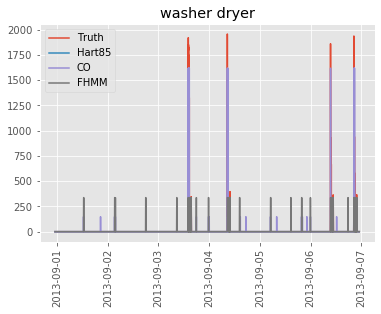

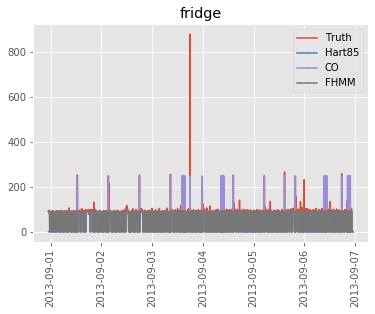

In [19]:
api_results_experiment_4 = API(experiment4)

In [20]:
errors_keys = api_results_experiment_4.errors_keys
errors = api_results_experiment_4.errors
for i in range(len(errors)):
    print (errors_keys[i])
    print (errors[i])
    print ("\n\n")

UKDALE_1_mae
                 Hart85        CO       FHMM
washer dryer  13.561829  5.786948  13.308846
fridge         9.062008  6.830959   7.406066



UKDALE_1_rmse
                  Hart85         CO       FHMM
washer dryer  116.758009  39.861043  96.706860
fridge         34.824637  28.681006  31.775599



UKDALE_1_f1score
                Hart85        CO      FHMM
washer dryer  0.000000  0.714044  0.597403
fridge        0.918268  0.967788  0.947484





## How Metrics work

The directory for the metrics that the API uses is stored in the following file:
<ul>
    <li><b><u>/opt/conda/envs/nilm-dev/lib/python3.6/site-packages/nilmtk/losses.py</u></b></li>
</ul>    

All losses take in two inputs:
<ul>
    <li><b>app_gt</b>: 1-dimensional series object containing ground truths of appliance energy use</li>
    <li><b>app_pred</b>: 1-dimensional series object containing predicted energy use of appliance by model</li>
    <ul>
        <li>app_gt and app_pred have the <b>same</b> dimensions</li>
    </ul>
</ul>

- Evaluations metrics are used to evaluate how well the prediction is done by the trained model.
- The predicted disaggregated load(s) are evaluated using a few evaluation metrics for regression loss:
    1. **MSE**
    2. **RMSE**
    3. **MAE**
    4. **MAPE**
- Computed results shows the error/loss values of predicted to ground truth
    - The pair with the least loss is considered the closest prediction or the more accurate prediction to ground truth
    
1. **Mean Squared Error (MSE)**
    - The mean squared error (MSE) tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them. It’s called the mean squared error as you’re finding the average of a set of errors. The lower the MSE, the better the prediction.
   
2. **Root Mean Squared Error (RMSE)**
    - Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit.
   
3. **Mean absolute error (MAE)**
    - Computes the mean of squares of errors between labeled data and predicted data. It calculates the absolute difference between the current output and the expected output divided by the number of output.
    
4. **F1 Score**
    <left>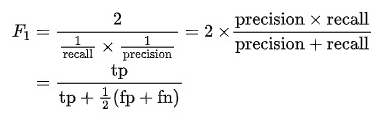</left>
    - Can be seen as a percentage, where 0% means it's performing badly and 100% means it's a perfect model
    - Can easily and quickly determine model effectiveness at just a glance

## Save Experiment Model as pickle
Functions used to export and import a trained model and the results

In [21]:
def export_model(model,filename):
    example_dict = model
    with open(filename, "wb") as pickle_out:
        pickle.dump(example_dict, pickle_out)

def import_model(filename):
    with open(filename, "rb") as pickle_in:
        model = pickle.load(pickle_in)
        #states = model['states']
        #appliance_name = model['appliance_name']
    return model

In [23]:
export_model(api_results_experiment_4,'modelTrained_api.pickle')

In [24]:
model = import_model('modelTrained_api.pickle')

## Plot model/experiment result
Plots the ground truth with disaggregated results from each trained model

In [25]:
def plot_result(model):
    plt.rcParams['figure.figsize'] = [15, 10]
    for i in model.gt_overall.columns:
        plt.figure()
        #plt.plot(model.test_mains[0],label='Mains reading')
        plt.plot(model.gt_overall[i],label='Truth')
        for clf in model.pred_overall:                
            plt.plot(model.pred_overall[clf][i],label=clf)
            plt.xticks(rotation=90)
        plt.title(i)
        plt.legend()
    plt.show()

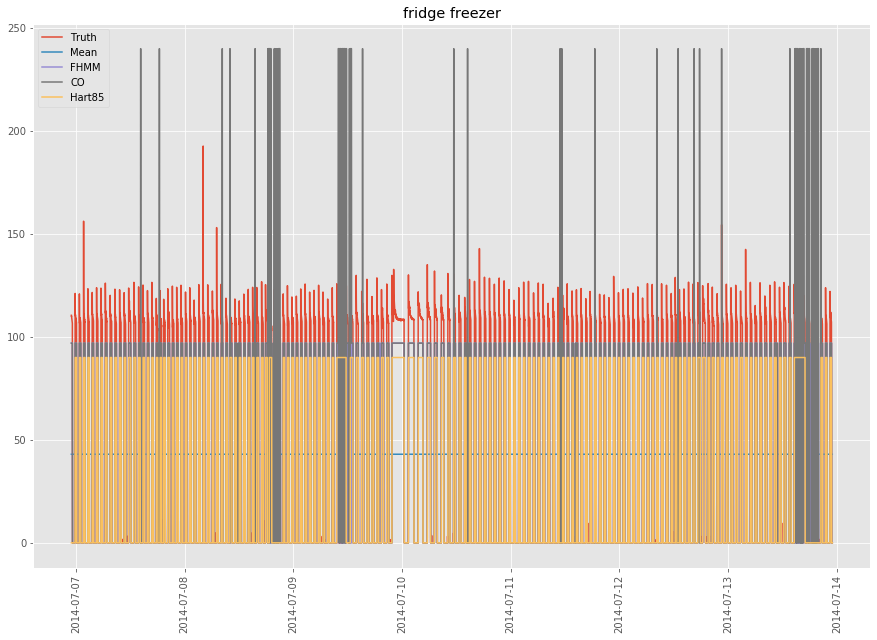

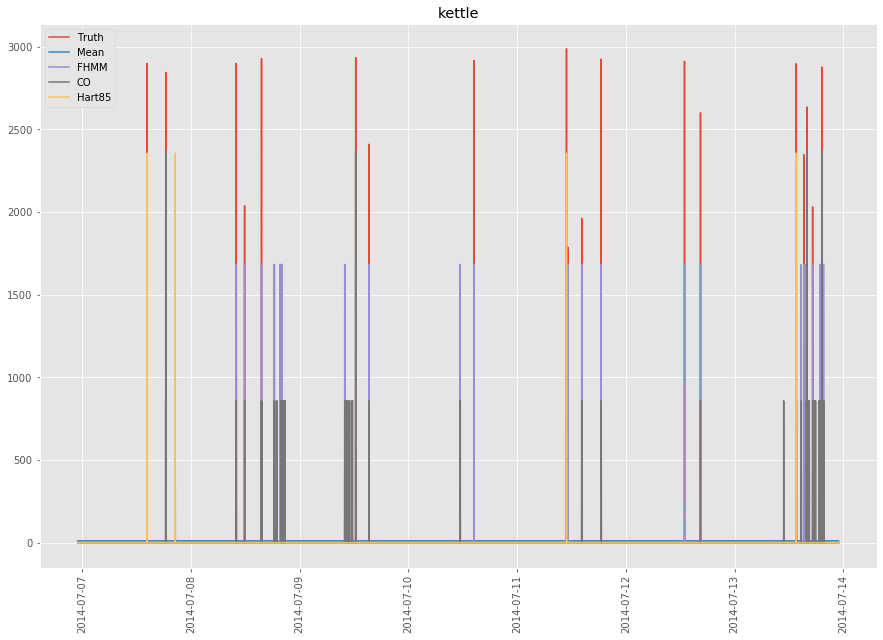

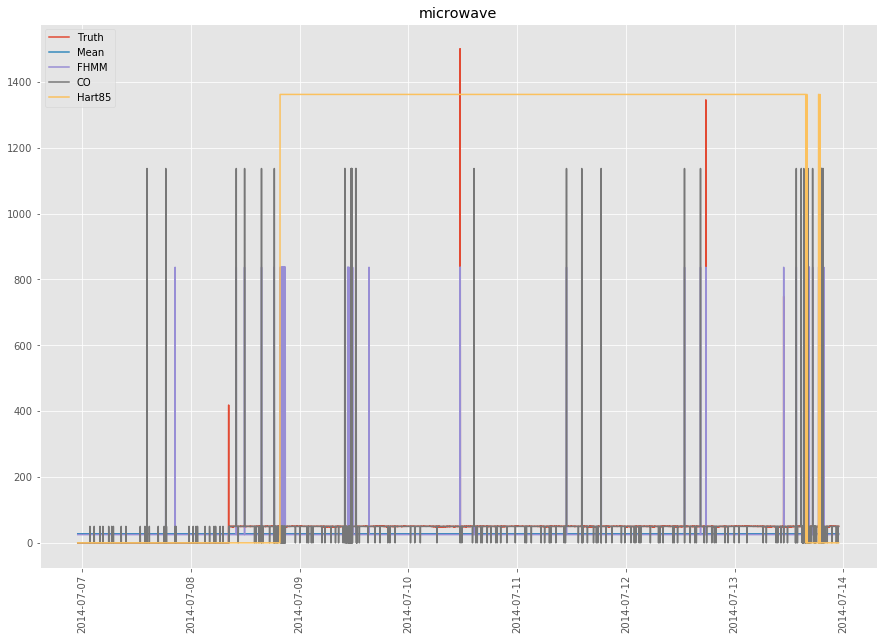

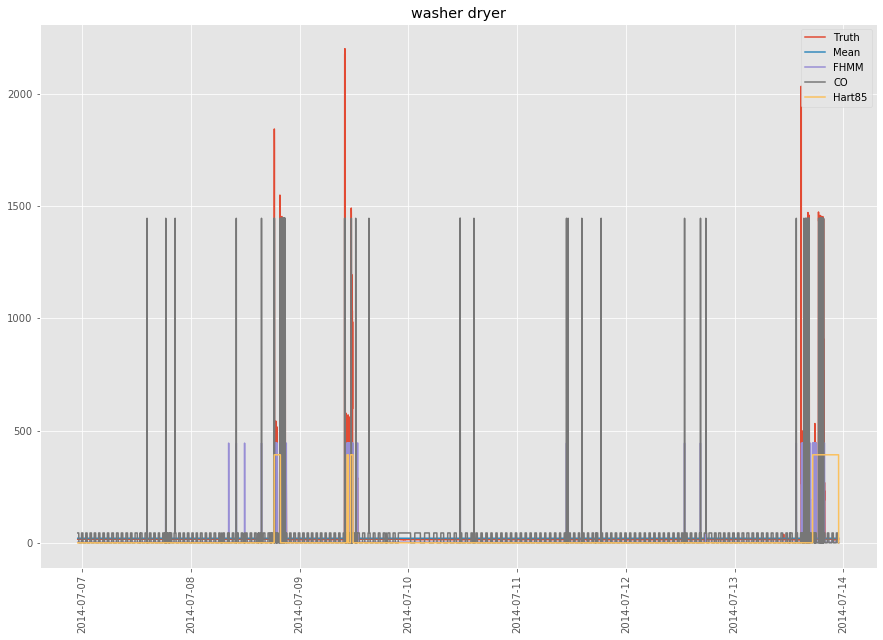

In [26]:
plot_result(api_results_experiment_3)